In [1]:
#importing Packages
import tensorflow as tf
import numpy as np


In [2]:
import os
from PIL import Image

# A function to load all the images from a certain folder
def load_images_from_folder(folder,label):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img = Image.open(os.path.join(folder, filename))
            # summarize some details about the image
            if img is not None:
                images.append((np.asarray(img)/255,label))

    return images

In [3]:
Normal_Images = load_images_from_folder("/kaggle/input/dataset/Normal_generated",0)


In [4]:
Precancer_Images = load_images_from_folder("/kaggle/input/dataset/Precancer_generated",1)

In [5]:
print("The length of Normal Images is {} and the length of Precancer Images list is {}".format(len(Normal_Images),len(Precancer_Images)))
Images = Normal_Images+Precancer_Images
print("The length of the combined set of images is {}".format(len(Images)))
import random as rand
# Shuffling the images to mix the precancer and normal Images
rand.shuffle(Images)

The length of Normal Images is 125 and the length of Precancer Images list is 72
The length of the combined set of images is 197


In [6]:
print('The shape of the images in the dataset is: ' , Images[0][0].shape)

The shape of the images in the dataset is:  (361, 181)


Using Kfold to cross validates

In [7]:
import numpy as np
from sklearn.model_selection import KFold

In [8]:

tf.keras.backend.clear_session()


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential()
model.add(Conv2D(64,kernel_size=3 ,input_shape = (361,181,1),activation = "relu")) #[1:] to skip the -1
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=3 ,activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten()) 

model.add(Dense(128,activation = "relu"))
model.add(Dense(1,activation = 'sigmoid'))

layer1model = model


In [4]:
layer1model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 359, 179, 64)      640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 179, 89, 64)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 177, 87, 128)      73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 88, 43, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 88, 43, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 484352)           

In [10]:
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


auc_metric = AUC()


In [11]:
import random
import numpy as np

def train_test_split(images, test_ratio=0.3):
    """Split an array of images with their corresponding labels into a training set and a testing set.

    Args:
        images (list): An array of tuples containing an image and its corresponding label.
        test_ratio (float): The ratio of the dataset to use for testing.

    Returns:
        Four numpy arrays: the training images, training labels,
        testing images, and testing labels.
    """
    for i in range(10):

        random.shuffle(images)  # Shuffle the data randomly.

        num_test = int(len(images) * test_ratio)

        # Split the data into a training set and a testing set.
        test_set = images[:num_test]
        train_set = images[num_test:]

        # Split the training set and testing set into separate arrays of images and labels.
        X_train, y_train = zip(*train_set)
        X_test, y_test = zip(*test_set)
        if len(X_train) == len(y_train) and len(X_test) == len(y_test):
            return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)



In [12]:
# Define a ModelCheckpoint callback to save the model with the highest mean validation AUC
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='saved_models/best_model',
    monitor='val_auc_1',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    save_format='tf',
    verbose=1
)


In [13]:
#!pip install tensorflow-addons

In [14]:
tp_metric = tf.keras.metrics.TruePositives()
tn_metric = tf.keras.metrics.TrueNegatives()
fp_metric = tf.keras.metrics.FalsePositives()
fn_metric = tf.keras.metrics.FalseNegatives()

In [15]:
tf.compat.v1.reset_default_graph()



In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import tensorflow_addons as tfa

tf.keras.backend.clear_session()

# Initialize the KFold object with 5 folds and shuffle the data before partitioning
kfold = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=42)
aucs = []
ss = []
tprs = []
fprs = []
# Loop through the folds and train the model on each fold
for i in range(10):
    X,y,X_test,Y_test = train_test_split(Images,0.2)
    # Use this in case of doing Transfer learning on a network that only accepts RGB
    #X = np.repeat(X[..., np.newaxis], 3, -1)
    #X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
    for train_index, val_index in kfold.split(X,y):
        model = layer2model
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc_metric])
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        history = model.fit(
          X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=20,
          callbacks=[callback],
          verbose = 1
        )
        
        # Calculate predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred > 0.5).astype(int)

        # Calculate confusion matrix
        cm = confusion_matrix(Y_test, y_pred_binary)

        # Update TP, TN, FP, FN
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        sensitivity = TPR
        specificity = 1 - FPR
        
        tprs.append(TPR)
        fprs.append(FPR)
        ss.append(specificity)

        _,auc= model.evaluate(X_test,Y_test)
        aucs.append(auc)
        
    tf.keras.backend.clear_session()

        

    

Epoch 1/20


2023-05-13 08:10:23.889421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 22s 1s/step - loss: 0.9689 - auc: 0.5323 - val_loss: 0.6682 - val_auc: 0.6583
Epoch 2/20
4/4 [==============================] - 1s 248ms/step - loss: 0.7573 - auc: 0.4758 - val_loss: 0.6750 - val_auc: 0.7604
Epoch 3/20
4/4 [==============================] - 1s 244ms/step - loss: 0.6629 - auc: 0.5823 - val_loss: 0.6764 - val_auc: 0.5750
Epoch 4/20
4/4 [==============================] - 1s 249ms/step - loss: 0.6721 - auc: 0.5630 - val_loss: 0.6575 - val_auc: 0.7333
Epoch 5/20
4/4 [==============================] - 1s 242ms/step - loss: 0.6580 - auc: 0.6178 - val_loss: 0.6604 - val_auc: 0.7417
Epoch 6/20
4/4 [==============================] - 1s 242ms/step - loss: 0.6687 - auc: 0.4677 - val_loss: 0.6581 - val_auc: 0.7500
Epoch 7/20
4/4 [==============================] - 1s 242ms/step - loss: 0.6614 - auc: 0.5170 - val_loss: 0.6573 - val_auc: 0.7812
Epoch 8/20
4/4 [==============================] - 1s 248ms/step - loss: 0.6580 - auc: 0.6042 - val_loss

2023-05-13 08:11:07.139105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 326ms/step - loss: 0.4971 - auc: 0.8606 - val_loss: 0.3955 - val_auc: 0.9812
Epoch 2/20
4/4 [==============================] - 1s 243ms/step - loss: 0.5202 - auc: 0.9090 - val_loss: 0.3996 - val_auc: 0.9917
Epoch 3/20
4/4 [==============================] - 1s 237ms/step - loss: 0.4332 - auc: 0.9386 - val_loss: 0.3651 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 239ms/step - loss: 0.3807 - auc: 0.9179 - val_loss: 0.2213 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 241ms/step - loss: 0.2589 - auc: 0.9723 - val_loss: 0.1557 - val_auc: 0.9979
Epoch 6/20
4/4 [==============================] - 1s 242ms/step - loss: 0.1968 - auc: 0.9778 - val_loss: 0.1365 - val_auc: 0.9958
Epoch 7/20
4/4 [==============================] - 1s 251ms/step - loss: 0.1649 - auc: 0.9841 - val_loss: 0.1209 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 245ms/step - loss: 0.1546 - auc: 0.9868 - val_lo

2023-05-13 08:11:22.417085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 324ms/step - loss: 0.6799 - auc: 0.8623 - val_loss: 0.7494 - val_auc: 0.9521
Epoch 2/20
4/4 [==============================] - 1s 251ms/step - loss: 0.4447 - auc: 0.9407 - val_loss: 0.3951 - val_auc: 0.9583
Epoch 3/20
4/4 [==============================] - 1s 233ms/step - loss: 0.3294 - auc: 0.9873 - val_loss: 0.2742 - val_auc: 0.9917
Epoch 4/20
4/4 [==============================] - 1s 241ms/step - loss: 0.1509 - auc: 1.0000 - val_loss: 0.3049 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 237ms/step - loss: 0.1080 - auc: 0.9939 - val_loss: 0.2268 - val_auc: 0.9958
Epoch 6/20
4/4 [==============================] - 1s 237ms/step - loss: 0.0754 - auc: 0.9989 - val_loss: 0.1487 - val_auc: 0.9958
Epoch 7/20
4/4 [==============================] - 1s 254ms/step - loss: 0.0672 - auc: 0.9987 - val_loss: 0.4339 - val_auc: 0.9917
Epoch 8/20
4/4 [==============================] - 1s 239ms/step - loss: 0.0355 - auc: 0.9997 - val_lo

2023-05-13 08:11:44.745578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 6s 1s/step - loss: 0.5783 - auc: 0.9317 - val_loss: 0.0104 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 231ms/step - loss: 0.2477 - auc: 0.9757 - val_loss: 0.2867 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 227ms/step - loss: 0.3621 - auc: 0.9672 - val_loss: 0.2958 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 229ms/step - loss: 0.3200 - auc: 0.9834 - val_loss: 0.1891 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 231ms/step - loss: 0.1522 - auc: 0.9950 - val_loss: 0.0357 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 233ms/step - loss: 0.0397 - auc: 0.9995 - val_loss: 0.0037 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 246ms/step - loss: 0.0314 - auc: 0.9995 - val_loss: 0.0016 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 247ms/step - loss: 0.0228 - auc: 0.9997 - val_loss:

2023-05-13 08:12:07.284137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 328ms/step - loss: 0.4867 - auc: 0.9339 - val_loss: 0.4246 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 237ms/step - loss: 0.2754 - auc: 0.9815 - val_loss: 0.2133 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 226ms/step - loss: 0.3080 - auc: 0.9846 - val_loss: 0.3912 - val_auc: 0.9583
Epoch 4/20
4/4 [==============================] - 1s 234ms/step - loss: 0.3091 - auc: 0.9935 - val_loss: 0.2222 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 228ms/step - loss: 0.1427 - auc: 0.9992 - val_loss: 0.1314 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 240ms/step - loss: 0.0610 - auc: 1.0000 - val_loss: 0.0378 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 236ms/step - loss: 0.0134 - auc: 1.0000 - val_loss: 0.0158 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 235ms/step - loss: 0.0039 - auc: 1.0000 - val_lo

2023-05-13 08:12:29.422081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 352ms/step - loss: 0.1462 - auc: 0.9534 - val_loss: 0.2385 - val_auc: 0.9729
Epoch 2/20
4/4 [==============================] - 1s 244ms/step - loss: 0.0571 - auc: 0.9992 - val_loss: 0.1771 - val_auc: 0.9729
Epoch 3/20
4/4 [==============================] - 1s 246ms/step - loss: 0.0173 - auc: 1.0000 - val_loss: 0.1067 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 235ms/step - loss: 0.0117 - auc: 1.0000 - val_loss: 0.1053 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 242ms/step - loss: 0.0070 - auc: 1.0000 - val_loss: 0.0915 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 237ms/step - loss: 0.0012 - auc: 1.0000 - val_loss: 0.1250 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 237ms/step - loss: 9.1773e-04 - auc: 1.0000 - val_loss: 0.1370 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 239ms/step - loss: 8.9672e-04 - auc: 1.0000 

2023-05-13 08:12:49.314597: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 318ms/step - loss: 0.1198 - auc: 0.9933 - val_loss: 0.0069 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 230ms/step - loss: 0.0541 - auc: 0.9996 - val_loss: 0.0658 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 228ms/step - loss: 0.0518 - auc: 0.9997 - val_loss: 0.0120 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 247ms/step - loss: 0.0139 - auc: 1.0000 - val_loss: 9.8081e-04 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 242ms/step - loss: 8.9736e-04 - auc: 1.0000 - val_loss: 4.5587e-04 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 237ms/step - loss: 3.0502e-04 - auc: 1.0000 - val_loss: 0.0016 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 237ms/step - loss: 4.7216e-04 - auc: 1.0000 - val_loss: 3.9241e-04 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 239ms/step - loss: 6.947

2023-05-13 08:13:11.549181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 326ms/step - loss: 0.0792 - auc: 0.9912 - val_loss: 0.5223 - val_auc: 0.9762
Epoch 2/20
4/4 [==============================] - 1s 238ms/step - loss: 0.2988 - auc: 0.9812 - val_loss: 0.0296 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 250ms/step - loss: 0.1522 - auc: 1.0000 - val_loss: 0.1628 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 231ms/step - loss: 0.0480 - auc: 1.0000 - val_loss: 0.0272 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 236ms/step - loss: 0.0346 - auc: 1.0000 - val_loss: 0.0542 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 237ms/step - loss: 0.0307 - auc: 1.0000 - val_loss: 0.0284 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 231ms/step - loss: 0.0093 - auc: 1.0000 - val_loss: 0.0131 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 230ms/step - loss: 0.0029 - auc: 1.0000 - val_lo

2023-05-13 08:13:33.816999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 368ms/step - loss: 0.1326 - auc: 0.9900 - val_loss: 0.2202 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 231ms/step - loss: 0.2743 - auc: 0.9938 - val_loss: 3.8698e-04 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 238ms/step - loss: 0.0087 - auc: 1.0000 - val_loss: 0.0037 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 229ms/step - loss: 0.0331 - auc: 1.0000 - val_loss: 0.0053 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 230ms/step - loss: 0.0123 - auc: 1.0000 - val_loss: 0.0020 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 239ms/step - loss: 0.0042 - auc: 1.0000 - val_loss: 2.7008e-04 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 232ms/step - loss: 0.0011 - auc: 1.0000 - val_loss: 3.1390e-05 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 233ms/step - loss: 0.0012 - auc: 1.0

2023-05-13 08:13:55.930081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 316ms/step - loss: 3.7792e-04 - auc: 0.9917 - val_loss: 7.3799e-06 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 234ms/step - loss: 6.5592e-07 - auc: 1.0000 - val_loss: 7.6304e-07 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 242ms/step - loss: 4.9891e-04 - auc: 1.0000 - val_loss: 5.7722e-05 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 232ms/step - loss: 2.6054e-05 - auc: 1.0000 - val_loss: 0.0843 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 232ms/step - loss: 0.0037 - auc: 1.0000 - val_loss: 6.9506e-04 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 231ms/step - loss: 2.5749e-04 - auc: 1.0000 - val_loss: 2.2152e-04 - val_auc: 1.0000
Epoch 7/20
2/2 [==============================] - 0s 18ms/step - loss: 0.0702 - auc: 0.9972
Epoch 1/20


2023-05-13 08:14:05.151243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 357ms/step - loss: 0.0389 - auc: 0.9989 - val_loss: 0.0125 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 227ms/step - loss: 0.0224 - auc: 1.0000 - val_loss: 0.0102 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 228ms/step - loss: 0.0011 - auc: 1.0000 - val_loss: 0.0362 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 238ms/step - loss: 6.9878e-04 - auc: 1.0000 - val_loss: 0.1272 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 234ms/step - loss: 0.0033 - auc: 1.0000 - val_loss: 0.0595 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 231ms/step - loss: 7.8593e-04 - auc: 1.0000 - val_loss: 0.0093 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 231ms/step - loss: 4.4642e-06 - auc: 1.0000 - val_loss: 0.0068 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 231ms/step - loss: 2.3267e-06 - auc:

2023-05-13 08:14:23.620291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 317ms/step - loss: 0.1155 - auc: 0.9900 - val_loss: 3.8660e-08 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 230ms/step - loss: 0.0085 - auc: 1.0000 - val_loss: 0.0229 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 235ms/step - loss: 0.0174 - auc: 1.0000 - val_loss: 0.0227 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 236ms/step - loss: 0.0070 - auc: 1.0000 - val_loss: 0.0046 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 227ms/step - loss: 0.0020 - auc: 1.0000 - val_loss: 0.0020 - val_auc: 1.0000
Epoch 6/20
2/2 [==============================] - 0s 23ms/step - loss: 0.2756 - auc: 0.9522
Epoch 1/20


2023-05-13 08:14:35.897864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 359ms/step - loss: 0.0036 - auc: 0.9913 - val_loss: 2.4820e-07 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 242ms/step - loss: 8.2899e-04 - auc: 1.0000 - val_loss: 0.0311 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 229ms/step - loss: 0.0042 - auc: 1.0000 - val_loss: 2.7097e-09 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 234ms/step - loss: 1.1829e-08 - auc: 1.0000 - val_loss: 4.2469e-10 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 237ms/step - loss: 4.1270e-06 - auc: 1.0000 - val_loss: 3.7693e-07 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 235ms/step - loss: 0.0080 - auc: 1.0000 - val_loss: 4.6730e-05 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 236ms/step - loss: 0.0639 - auc: 0.9936 - val_loss: 2.4189e-04 - val_auc: 1.0000
Epoch 8/20
4/4 [==============================] - 1s 237ms/step -

2023-05-13 08:14:47.830009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 316ms/step - loss: 2.6787e-04 - auc: 0.9914 - val_loss: 9.8913e-14 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 238ms/step - loss: 2.8417e-11 - auc: 1.0000 - val_loss: 8.6489e-16 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 241ms/step - loss: 3.6899e-06 - auc: 1.0000 - val_loss: 5.7655e-12 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 250ms/step - loss: 2.1656e-07 - auc: 1.0000 - val_loss: 4.7739e-17 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 243ms/step - loss: 2.5557e-15 - auc: 1.0000 - val_loss: 1.0645e-19 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 246ms/step - loss: 7.5941e-14 - auc: 1.0000 - val_loss: 4.8770e-17 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 244ms/step - loss: 2.3235e-10 - auc: 1.0000 - val_loss: 1.1964e-14 - val_auc: 1.0000
Epoch 8/20
4/4 [=============================

2023-05-13 08:15:00.029449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 321ms/step - loss: 2.1012e-13 - auc: 0.9953 - val_loss: 1.8501e-15 - val_auc: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 244ms/step - loss: 2.7176e-12 - auc: 1.0000 - val_loss: 1.8323e-15 - val_auc: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 244ms/step - loss: 1.0810e-09 - auc: 1.0000 - val_loss: 2.5101e-17 - val_auc: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 243ms/step - loss: 7.1717e-14 - auc: 1.0000 - val_loss: 2.1969e-18 - val_auc: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 244ms/step - loss: 7.4232e-14 - auc: 1.0000 - val_loss: 2.2432e-18 - val_auc: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 252ms/step - loss: 4.7451e-15 - auc: 1.0000 - val_loss: 4.6114e-18 - val_auc: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 243ms/step - loss: 1.3358e-15 - auc: 1.0000 - val_loss: 8.1323e-18 - val_auc: 1.0000
Epoch 8/20
4/4 [=============================

In [21]:
len(fprs)

15

In [22]:
tprs

[0.5384615384615384,
 0.8461538461538461,
 0.8461538461538461,
 0.6153846153846154,
 0.6153846153846154,
 1.0,
 1.0,
 0.9333333333333333,
 0.8666666666666667,
 1.0,
 1.0,
 0.9166666666666666,
 0.9166666666666666,
 1.0,
 1.0]

In [23]:
np.mean(tprs)

0.872991452991453

In [24]:
mean_fpr = np.mean(fprs)
mean_tpr = np.mean(tprs)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)



In [26]:
mean_tpr

0.872991452991453

In [27]:
1-mean_fpr

0.9694919278252612

In [ ]:
from scipy.stats import t

mean = np.mean(aucs)
se = np.std(aucs) / np.sqrt(len(X))

# Calculate the 95% confidence interval
alpha = 0.05
df = len(X) - 1
ci = t.interval(1 - alpha, df=df, scale=se)

print(f'95% confidence interval: [{mean + ci[0]:.4f}, {mean + ci[1]:.4f}]')
print(f'mean AUC scoring {mean:.3f}')

In [ ]:
mean = np.mean(accs)
se = np.std(accs) / np.sqrt(len(X))

# Calculate the 95% confidence interval
alpha = 0.05
df = len(X) - 1
ci = t.interval(1 - alpha, df=df, scale=se)

print(f'95% confidence interval: [{mean + ci[0]:.4f}, {mean + ci[1]:.4f}]')
print(f'mean Accuracy scoring {mean:.3f}')

In [ ]:
mean = np.mean(sas)
se = np.std(sas) / np.sqrt(len(X))

# Calculate the 95% confidence interval
alpha = 0.05
df = len(X) - 1
ci = t.interval(1 - alpha, df=df, scale=se)

print(f'95% confidence interval: [{mean + ci[0]:.4f}, {mean + ci[1]:.4f}]')
print(f'mean Sensitivity at specifity 0.5 scoring {mean:.3f}')

In [ ]:
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {acc:.4f}')
print(f'Test AUC: {auc:.4f}')

In [ ]:

best_model.summary()


In [5]:

model = Sequential()
model.add(Conv2D(64,kernel_size=3 ,input_shape = (361,181,1),activation = "relu")) #[1:] to skip the -1
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=3 ,activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,kernel_size=3 ,activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten()) 

model.add(Dense(256,activation = "relu"))
model.add(Dense(128,activation = "relu"))
model.add(Dense(1,activation = 'sigmoid'))

layer2model = model

In [6]:
layer2model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 359, 179, 64)      640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 179, 89, 64)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 177, 87, 128)      73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 88, 43, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 41, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 20, 256)     

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [7]:

model = Sequential()
model.add(Conv2D(64,kernel_size=3 ,input_shape = (361,181,1),activation = "relu")) #[1:] to skip the -1
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=3 ,activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,kernel_size=3 ,activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512,kernel_size=3 ,activation = "relu"))


model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten()) 

model.add(Dense(512,activation = "relu"))
model.add(Dense(256,activation = "relu"))
model.add(Dense(128,activation = "relu"))
model.add(Dense(1,activation = 'sigmoid'))

layer3model = model

In [8]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 359, 179, 64)      640       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 179, 89, 64)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 177, 87, 128)      73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 88, 43, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 86, 41, 256)       295168    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 20, 256)     

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization


In [10]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

In [11]:
#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(361,181,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

In [13]:
#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

In [14]:
#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))


In [16]:
#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

In [17]:
#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('sigmoid'))

In [18]:
AlexNet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 91, 46, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 91, 46, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 91, 46, 96)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 46, 23, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 46, 23, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 23, 256)     

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

vgg = VGG16(input_shape=(361, 181, 3), include_top=False, weights='imagenet')
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
VGG = Model(inputs=vgg.input, outputs=x)



58889256/58889256 [==============================] - 0s 0us/step


In [20]:
VGG.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 361, 181, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 361, 181, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 361, 181, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 90, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 90, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 90, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 90, 45, 128)       0     

In [21]:
from tensorflow.keras.applications import InceptionV3
# Load the pretrained InceptionV3 model
inception = InceptionV3(input_shape=(361, 181, 3), weights='imagenet', include_top=False)

# Freeze the weights of the pretrained layers
for layer in inception.layers:
    layer.trainable = False

# Add your own classification layers on top of the frozen pretrained layers
x = Flatten()(inception.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create a new model with your added classification layers
InceptionV3 = Model(inputs=inception.input, outputs=x)

87910968/87910968 [==============================] - 0s 0us/step


In [22]:
InceptionV3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 361, 181, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 180, 90, 32)  864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 180, 90, 32)  96         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [23]:
LeNET = tf.keras.models.Sequential()
LeNET.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(361, 181, 1)))
LeNET.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
LeNET.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
LeNET.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
LeNET.add(tf.keras.layers.Flatten())
LeNET.add(tf.keras.layers.Dense(units=120, activation='relu'))
LeNET.add(tf.keras.layers.Dense(units=84, activation='relu'))
LeNET.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [24]:
LeNET.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 357, 177, 6)       156       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 178, 88, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 174, 84, 16)       2416      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 87, 42, 16)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 58464)             0         
                                                                 
 dense_19 (Dense)            (None, 120)              

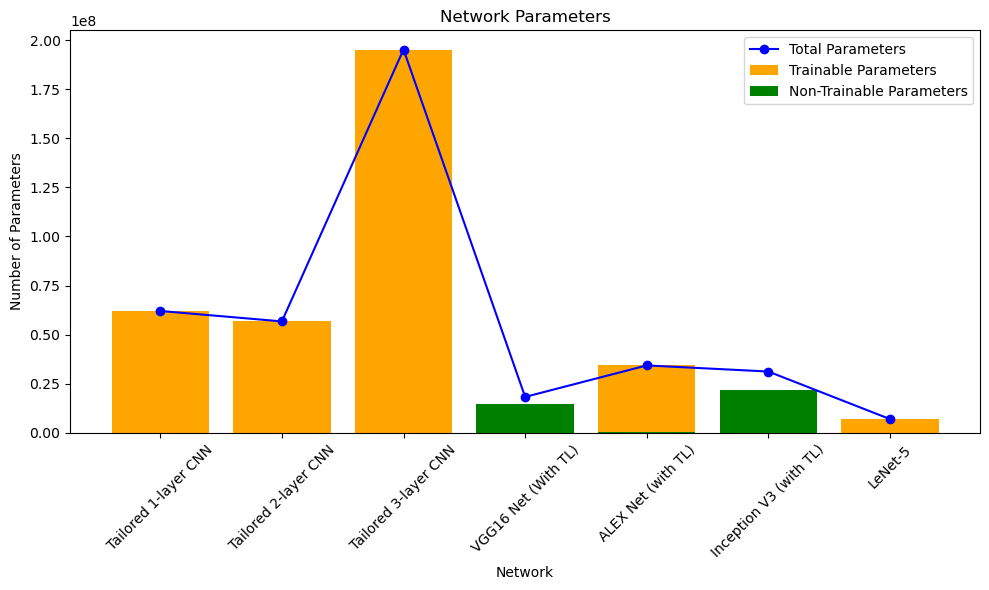

In [38]:
import matplotlib.pyplot as plt

networks = [
    "Tailored 1-layer CNN",
    "Tailored 2-layer CNN",
    "Tailored 3-layer CNN",
    "VGG16 Net (With TL)",
    "ALEX Net (with TL)",
    "Inception V3 (with TL)",
    "LeNet-5"
]

total_parameters = [
    62071809,
    56763905,
    195176961,
    18319425,
    34353461,
    31240225,
    7028621
]

trainable_parameters = [
    62071809,
    56763905,
    195176961,
    3604737,
    34330531,
    9437441,
    7028621
]

non_trainable_parameters = [
    0,
    0,
    0,
    14714688,
    229300,
    21802784,
    0
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(networks, total_parameters, label='Total Parameters', color='blue',marker = 'o')
plt.bar(networks, trainable_parameters, label='Trainable Parameters', color='orange')
plt.bar(networks, non_trainable_parameters, label='Non-Trainable Parameters', color='green')

plt.xlabel('Network')
plt.ylabel('Number of Parameters')
plt.title('Network Parameters')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


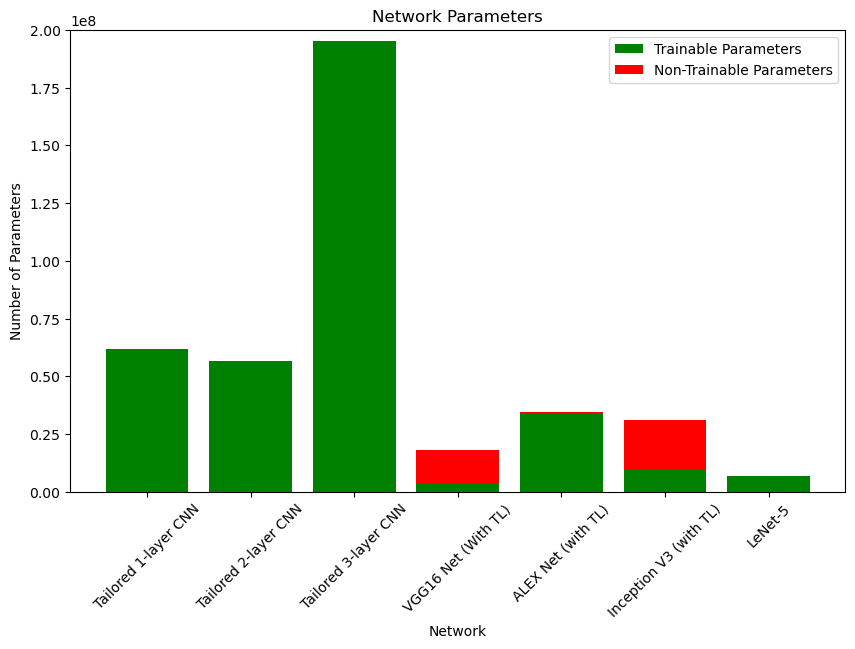

In [39]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting trainable parameters as stacked bars
plt.bar(networks, trainable_parameters, label='Trainable Parameters', color='green')

# Plotting non-trainable parameters as stacked bars on top of trainable parameters
plt.bar(networks, non_trainable_parameters, bottom=trainable_parameters,
        label='Non-Trainable Parameters', color='red')

plt.xlabel('Network')
plt.ylabel('Number of Parameters')
plt.title('Network Parameters')

plt.xticks(rotation=45)
plt.ylim(0,200000000)
plt.legend()
plt.show()
